# LSTM Model 
**Group:** HDer  
**Group Members:**  
Shu Wang (z5211077)  
Wanxiao Huang (z5222629)  
Wanting Zhou (z5347036)  
Kanghong Yu (z5413510)  
Yinglu  Yang (z5390317) 

This notebook is only for LSTM Model. We use a seperate notebook because training of this model takes too long.    
If you want to run this notebook, please run the main notebook first to get files need for the notebook.

In [3]:
import numpy as np
import pandas as pd

In [4]:
root_dir = ''
index2word_path = root_dir + "index2word.npy" # index2word[idx] = word (list)
word2index_path = root_dir + "word2index.npy" # word2index[word] = idx (dict)
index2vec_path = root_dir + "index2vec.npy" # index2vec[idx] = vector (100D)
train_ids_npy_path = root_dir + "train_ids.npy"
test_ids_npy_path = root_dir + "test_ids.npy"
train_label_npy_path = root_dir + "train_labels.npy"
test_label_npy_path = root_dir + "test_labels.npy"

# file for sample vector files (180,000 and 20,000)
sample_train_vectors_npy_path = root_dir + "sample_train_vectors.npy"
sample_test_vectors_npy_path = root_dir + "sample_test_vectors.npy"
sample_train_label_npy_path = root_dir + "sample_train_labels.npy"
sample_test_label_npy_path = root_dir + "sample_test_labels.npy"

In [5]:
# read .npy file 
X_train = np.load(train_ids_npy_path, allow_pickle=True)
test_id_list = np.load(test_ids_npy_path, allow_pickle=True)
y_train = np.load(train_label_npy_path, allow_pickle=True)
test_label = np.load(test_label_npy_path, allow_pickle=True)

In [6]:
index2word = np.load(index2word_path, allow_pickle=True)
word2index = np.load(word2index_path, allow_pickle=True).item()
index2vec = np.load(index2vec_path, allow_pickle=True)

In [7]:
# split the test set into validation set and test set
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(test_id_list, test_label, test_size=0.5, shuffle=False)

In [8]:
print("The size of traning dataset", len(X_train))
print("The size of validation dataset", len(X_val))
print("The size of testing dataset", len(X_test))

The size of traning dataset 1800000
The size of validation dataset 100000
The size of testing dataset 100000


## LSTM model

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import math

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [14]:
class LSTMNet(nn.Module):
    """
    hidden_dim: the number of hidden nodes
    num_layers: the number of layers
    index2vec: the trained word vector
    vocab_size: the size of the vocabulary, 247241
    output_size: this is a binary classification, so it is 1
    embedding_dim: the dimension of each word, 100
    """
    def __init__(self, hidden_dim, num_layers, index2vec=index2vec, vocab_size=len(word2index), output_size=1, embedding_dim=100, drop_prob=0.5):
        super(LSTMNet, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # import trained word vector and set the back propagation to False
        self.embedding.weight.data.copy_(torch.from_numpy(index2vec))
        self.embedding.weight.requires_grad = False
        
        # define the LSTM
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, self.num_layers, dropout=drop_prob, batch_first=True)
        # 20% dropout
        self.dropout = nn.Dropout(0.2)
        # connect to fully connected layers
        self.fc = nn.Linear(self.hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # initialize hidden state, set all to zero
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device),
              weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

        
    def forward(self, x, hidden):
        """
        x: the current input, (batch_size, setence_len)
        hidden: the hidden state and cell state in the last moment, tuple (h,c)
        """
        batch_size = x.size(0)
        # change the type of x to LongTensor
        x = x.long()
        # words embedding 
        # embeds.shape: torch.Size([batch_size, setence_len, embedding_dim])
        embeds = self.embedding(x)
        # lstm_out: torch.Size([batch_size, setence_len, hidden_dim])
        # hidden: (hidden_state, cell_state), torch.Size([num_layers, batch_size, hidden_dim])
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)

        # out:torch.Size([batch_size, setence_len])
        out = out.view(batch_size, -1)
        # out:torch.Size([batch_size])
        out = out[:,-1]
        return out, hidden

In [15]:
hidden_dim = 192
num_layers = 2

model = LSTMNet(hidden_dim, num_layers)
model = model.to(device)
print(model)

LSTMNet(
  (embedding): Embedding(247241, 100)
  (lstm): LSTM(100, 192, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=192, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [21]:
batch_size = 200

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [18]:
lr=0.001
# Since this is a bianry classfication, we use Binary Cross Entropy(BCE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Train model

In [ ]:
epochs = 4
counter = 0
valid_loss_min = np.Inf


model.train()
history_train = []
history_test = []
for i in range(epochs):
    print(f"--------------- Epoch: {i+1} ---------------")
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        # clear the gradient
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # clip gradients computed during backpropagation to avoid explosion of gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        
        if counter%1000 == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            history_train.append(round(loss.item(), 3))
            history_test.append(round(np.mean(val_losses), 3))
            print(f"Step: {counter},Train Loss: {loss.item():.6f},Val Loss: {np.mean(val_losses):.6f}")
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), root_dir + 'best_model.pt')
                print(f'Validation loss decreased ({valid_loss_min:.6f} --> {np.mean(val_losses):.6f}).  Saving model ...')
                valid_loss_min = np.mean(val_losses)

--------------- Epoch: 1 ---------------
Step: 1000,Train Loss: 0.130010,Val Loss: 0.186140
Validation loss decreased (inf --> 0.186140).  Saving model ...
Step: 2000,Train Loss: 0.149495,Val Loss: 0.183250
Validation loss decreased (0.186140 --> 0.183250).  Saving model ...
Step: 3000,Train Loss: 0.277802,Val Loss: 0.179787
Validation loss decreased (0.183250 --> 0.179787).  Saving model ...
Step: 4000,Train Loss: 0.154290,Val Loss: 0.177877
Validation loss decreased (0.179787 --> 0.177877).  Saving model ...
Step: 5000,Train Loss: 0.158344,Val Loss: 0.178531
Step: 6000,Train Loss: 0.211532,Val Loss: 0.176543
Validation loss decreased (0.177877 --> 0.176543).  Saving model ...
Step: 7000,Train Loss: 0.133209,Val Loss: 0.175194
Validation loss decreased (0.176543 --> 0.175194).  Saving model ...
Step: 8000,Train Loss: 0.226627,Val Loss: 0.174407
Validation loss decreased (0.175194 --> 0.174407).  Saving model ...
Step: 9000,Train Loss: 0.187748,Val Loss: 0.172645
Validation loss decrea

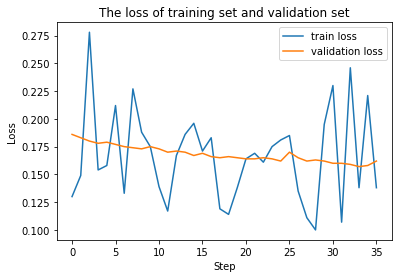

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_train, label="train loss")
plt.plot(history_test, label="validation loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("The loss of training set and validation set")
plt.show()

Test model

In [22]:
model.load_state_dict(torch.load(root_dir + 'LSTM_best_model.pt'))

test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)
predicted_y = []

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze()) #rounds the output to 0/1
    for p in pred.tolist():
      predicted_y.append(int(p))
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
        
print(f"Test loss: {np.mean(test_losses):.3f}")
test_acc = num_correct/len(test_loader.dataset)
print(f"Test accuracy: {(test_acc*100):.3f}%")

Test loss: 0.166
Test accuracy: 94.150%


In [24]:
from sklearn.metrics import classification_report
report = classification_report(y_test, predicted_y)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       994
           1       0.94      0.95      0.94      1006

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



| | precision | recall | f1-score |
|:--:|:--:|:--:|:--:|
|0|0.95|0.94|0.94|
|1|0.94|0.95|0.94|
|accuracy | | |0.94|
|weighted avg |0.94|0.94|0.94|

In [30]:
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(y_test, predicted_y)
print("confusion matrix\n", con_matrix)

confusion matrix
 [[930  64]
 [ 53 953]]


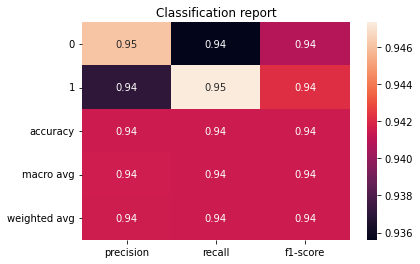

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(pd.DataFrame(classification_report(
         y_test, predicted_y, zero_division=0.0,output_dict=True)).iloc[:-1, :].T, annot=True)
plt.title('Classification report')
plt.show()

## Model Analysis

From the above classfication report and confusion matrix, it is obvious that micro and macro metircs are quite close, so this is a balance dataset.The original accuracy is 92.388%. But after all work have done, we changed the dropout from 0.5 to 0.2 to get a more optimal model. The accuracy of the new model is 94.15%, which is higher than 92.388%. This is probobaly beacuse the high dropout caused some information loss and LSTM failed to predict correctly. During the hyperparamter tuning, I changed the number of epochs and batch size manullay, the accuracy was always around 90% and it took 30 minutes to run each epoch. So there are still more I can improve in the future, I may use RandomSearchCV function to find much better parameters for LSTM model. 